## Analyze the Performance in Orange Thresh
 - and build recipes for perf analysis in general

In [16]:
import os, sys, copy, random, pickle
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from modules.Interproc import DBInterface
from modules.Interproc import GuiviewState
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.ImgUtils import (filter_pixels_circle, crop_img)

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, EvalTracker, presetCubeViews, bytesToPic,
         croppedPic, bytesToPic2, colorInRange)

from skimage.filters import sobel, gaussian, scharr, threshold_adaptive

from modules.IterThresh import iterThreshA
from modules.AnalysisHelpers import imgToColors, pointsToList

from modules.AnalysisHelpers import (applyTracker, roiSelectZoomWindow,
                                     roiSelectScoreWindow)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data - baseframes

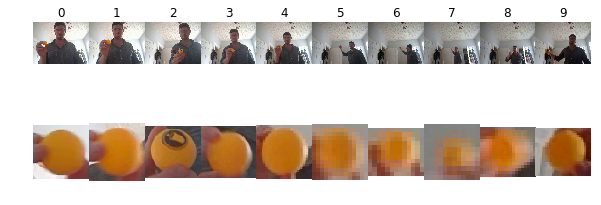

In [2]:
DATA_DIR = "../data/misc/books/analyze-orange-thresh-2/"

db_name = "gs_baseframes.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGS = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

chart_data = []

for _gs in listGS:
    _gs.initDisplay()
    tmp = []
    tmp.append(_gs.getOrigFrame())
    tmp.append(_gs.display.scoreFrame.copy())
    chart_data.append(tmp)

multiPlot( chart_data, hspace = 0, wspace = 0, figsize = (10,4)
          ,input_frame_titles = range(len(chart_data))
          ,bForceTitles = False
          ,bGrid=False)

### Create two frames of interest: good_gs and bad_gs
 - bad_gs has tracking that is wrong but tricky to diagnose b/c it is capturing finger

In [17]:
good_gs, bad_gs = listGS[0], listGS[8]
print good_gs.frameCounter, bad_gs.frameCounter

0 307


In [4]:
tracker = TrackFactory(on=True)
tracker.setInit(ballColor = "orange")
tracker.setAlgoEnum(1)

tracker.setFrame(good_gs.getOrigFrame())
tracker.trackFrame()
trackScore = tracker.getTrackScore()
trackRegion = trackScore['0']['data']
print 'trackRegion: ' , str(trackRegion)

scoreRegion = good_gs.displayInputScore['0']['data']
print 'scoreRegion: ', str(scoreRegion)

trackRegion:  (100, 210, 65, 65)
scoreRegion:  [107, 214, 54, 52]


### Demo using gs.getScoreWindow()

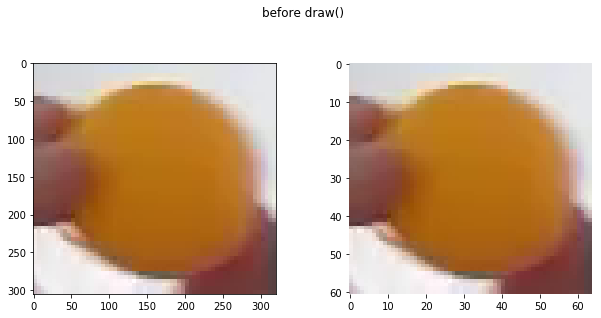

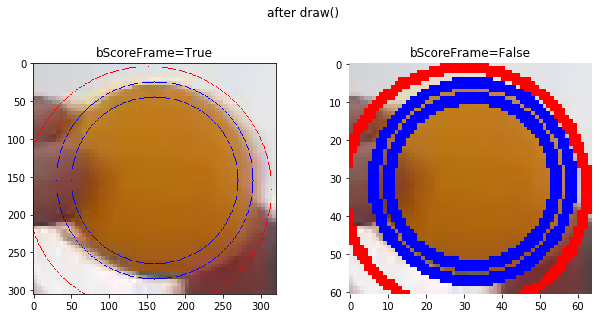

In [5]:
good_gs.initDisplay()

chart_data = [
     [good_gs.getScoreWindow()]
    ,[good_gs.getScoreWindow(bScoreFrame=False)]
]

good_gs.drawTracker(trackRect = trackRegion )
good_gs.drawOperator(scoreRect = scoreRegion )

chart_data2 = [
     [good_gs.getScoreWindow()]
    ,[good_gs.getScoreWindow(bScoreFrame=False)]
]

multiPlot(chart_data, input_figure_title = "before draw()", figsize = (10,5))

multiPlot(chart_data2, input_figure_title = "after draw()", figsize = (10,5)
         , input_frame_titles = ["bScoreFrame=True", "bScoreFrame=False"])

### Side by Side Evaluation Results

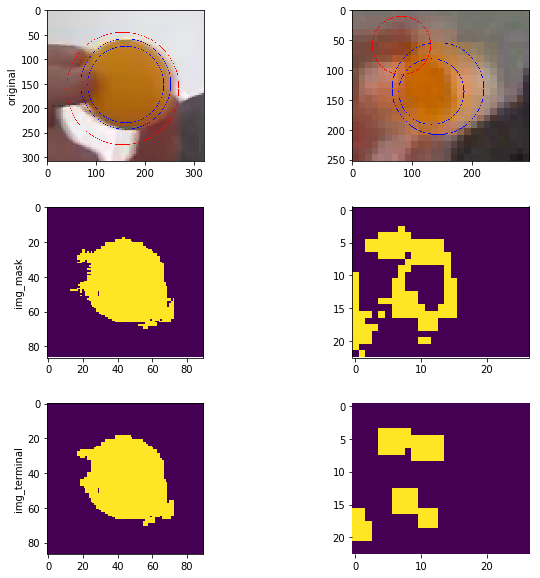

In [18]:
# multiPlot with drawnScoreWindow, then with trackerSteps

def buildPlts(listGS, tracker):
    ''' show scoreFrame annotated and '''
    
    img_data = []
    
    for _gs in listGS:
        
        _tmp = []
        
        # scoreframe with track/score annotations
        
        tracker.setFrame(_gs.getOrigFrame())
        track_log = tracker.trackFrame(b_log=True)
        track_score = tracker.getTrackScore()
        
        _gs.initDisplay(zoomFct=0.5)
        _gs.drawTracker(track_score['0']['data'])
        _gs.drawOperator(_gs.displayInputScore['0']['data'])
        
        img = _gs.getScoreWindow()
        
        _tmp.append(img)
        
        # scoreframe tracker modified mask(s)
        
        _gs.initDisplay(zoomFct=0.5)
        cropped_img = _gs.getScoreWindow(bScoreFrame=False)
        
        tracker.setFrame(cropped_img)
        track_log = tracker.trackFrame(b_log=True)
        
        logs_of_interest = ['img_mask', 'img_terminal']
        
        for _log_key in logs_of_interest:
            
            _tmp.append(track_log[_log_key])

        img_data.append(_tmp)
        
    return img_data

foiList = [good_gs, bad_gs]

chart_data = buildPlts(foiList, tracker)

multiPlot(chart_data, input_transform_titles = 
          ['original', 'img_mask', 'img_terminal'])


In [66]:
data = applyTracker(listGS, tracker, roiSelectScoreWindow)
_data = data['listPlts']

frames = len(data['listPlts'])
viewsOfInterest = [0,3]

col1, col2 = [], []

for _frame in range(frames) :
        
    col1.append( _data[_frame][viewsOfInterest[0]] )

    col2.append( _data[_frame][viewsOfInterest[1]])

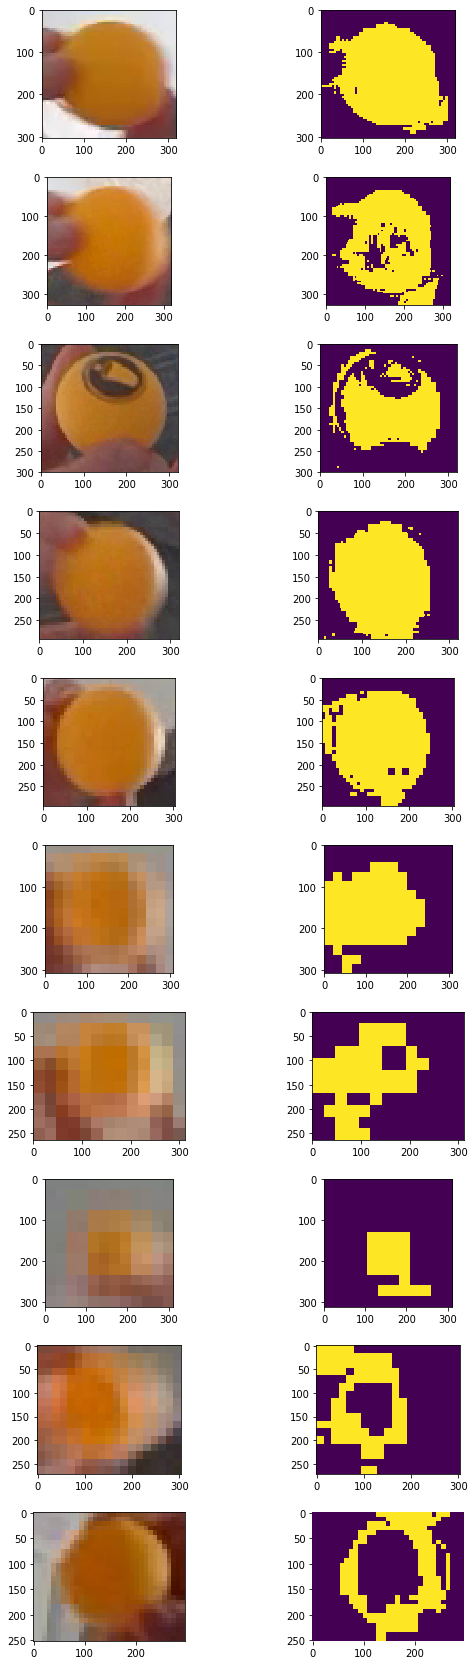

In [67]:
chart_data = [col1, col2]

multiPlot( chart_data
#           ,input_frame_titles = data['listTransformTitles']
#           ,input_transform_titles = data['listFrameTitles']
         ,wspace = 0 
         ,figsize = (10,30)
         )

In [63]:
import pandas as pd

In [ ]:
pd.DataFrame()